# Fragile Families Challenge
## Onur Varol
@onurvarol | www.onurvarol.com

In [12]:
%pylab inline
import os, sys, glob, copy
import gzip

import json
import pickle
import pandas as pd

import matplotlib.pylab as plt

from data_access import *

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [13]:
modelPerformance = dict()
for fname in glob.glob('experiments/*.pkl'):
    exp = pickle.load(open(fname, 'rb'))
    #print exp['model']
    scores = [fold['mse'] for fold in exp['folds']]
    print fname, np.mean(scores)
    
    tname = fname.split('.')[0].split('_')[-1]
    tname = tname#.replace('materialHardship','material_hardship').replace('jobTraining','job_training')
    if tname not in modelPerformance:
        modelPerformance[tname] = list()
    
    modelPerformance[tname].append(np.mean(scores))

print {m:min(modelPerformance[m]) for m in modelPerformance}

experiments/results_corefeatures_RFclassification_10CV_eviction.pkl 0.0596457250827
experiments/results_corefeatures_RFclassification_10CV_jobTraining.pkl 0.236170906719
experiments/results_corefeatures_RFclassification_10CV_layoff.pkl 0.209048966535
experiments/results_corefeatures_RFregression_10CV_eviction.pkl 0.0596999844119
experiments/results_corefeatures_RFregression_10CV_gpa.pkl 0.369400429331
experiments/results_corefeatures_RFregression_10CV_grit.pkl 0.229014590232
experiments/results_corefeatures_RFregression_10CV_jobTraining.pkl 0.174729562483
experiments/results_corefeatures_RFregression_10CV_layoff.pkl 0.169600283588
experiments/results_corefeatures_RFregression_10CV_materialHardship.pkl 0.0198308515988
experiments/results_corefeatures_TPOT_eviction.pkl nan
experiments/results_corefeatures_TPOT_gpa.pkl nan
experiments/results_corefeatures_TPOT_grit.pkl nan
experiments/results_corefeatures_TPOT_jobTraining.pkl nan
experiments/results_corefeatures_TPOT_layoff.pkl nan
experi

/Users/onurvarol/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/onurvarol/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[Errno 2] No such file or directory: 'data/submissions/10/scores.txt'
['1705', 'ovarol', '0.36571 (1)', '0.21812 (15)', '0.02481 (5)', '0.05660 (27)', '0.17422 (15)', '0.20225 (14)', '']


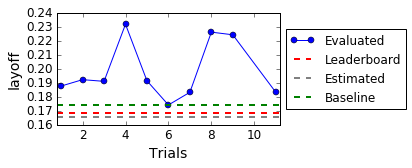

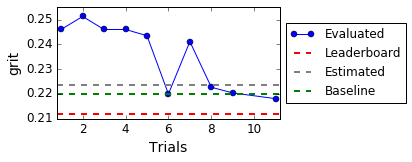

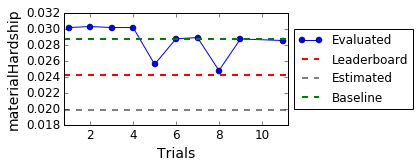

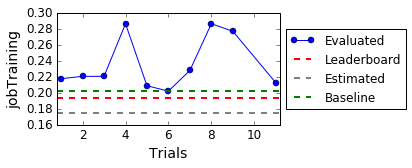

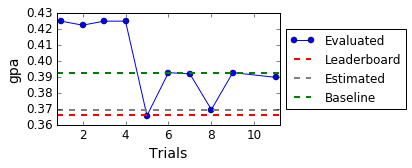

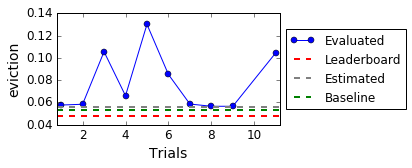

In [22]:
rename = [('material_hardship','materialHardship'), 
          ('job_training','jobTraining')
         ]

baselines = {'gpa':0.39273, 'grit':0.21997, 'materialHardship':0.0288,
             'eviction':0.05341, 'layoff':0.17435, 'jobTraining':0.20224}

outcomes = set()
scores = dict()
submissionFiles = dict()
for d in os.listdir('data/submissions/'):
    if d.startswith('.') or d.endswith('csv') or d.startswith('the_best'):
        continue
    
    try:
        tempS = dict()
        with open('data/submissions/{}/scores.txt'.format(d),'r') as fl:
            for line in fl:
                temp = line.strip().replace(' ','').split(':')
                oname = temp[0].lower()
                
                for r in rename:
                    oname = oname.replace(r[0],r[1])

                outcomes.add(oname)
                tempS[oname] = float(temp[1])
        scores[int(d)] = tempS
        submissionFiles[int(d)] = 'data/submissions/{}/prediction.csv'.format(d)
    except Exception as e:
        print e
    
#resultDf = pd.read_csv('data/submissions/Fragile Families Challenge results.csv')
bestResult = dict()
with open('data/submissions/Fragile Families Challenge results.csv', 'r') as fl:
    header = list() #[h.replace(' ','_').lower() for h in fl.readline().strip().split(',')]
    for h in fl.readline().strip().split(','):
        temp = h.replace(' ','_').lower()
        for r in rename:
            temp = temp.replace(r[0],r[1])
        header.append(temp)
        
    bestResult = {h:100 for h in header[2:]}
    for line in fl:
        temp = line.strip().split(',')
        if len(temp) < len(header):
            continue
            
        if temp[1] == 'ovarol': # Skip my own scores
            print temp
            continue
        
        for i,h in enumerate(header[2:]):
            score = float(temp[2+i].split(' ')[0])
            bestResult[h] = min(bestResult[h], score)
            
for oc in outcomes:
    if oc not in bestResult:
        continue
    plt.figure(figsize=(4,2))
    
    plt.plot(sorted(scores.keys()), [scores[x][oc] for x in scores], 
             'o-', label='Evaluated')
    
    plt.axhline(bestResult[oc], 
                label='Leaderboard',
                linestyle='--', color='r', linewidth=2)
    
    plt.axhline(min(modelPerformance[oc]), 
                label='Estimated',
                linestyle='--', color='0.5', linewidth=2)
    
    plt.axhline(baselines[oc], 
                label='Baseline',
                linestyle='--', color='g', linewidth=2)
    
    
    #for v in modelPerformance[oc]:
    #    plt.axhline(v, linestyle='-', color='g', linewidth=1, alpha=0.5)
    
    plt.xlim((0.8,max(scores.keys())+0.2))
    plt.ylabel(oc, fontsize=14)
    plt.xlabel('Trials', fontsize=14)
    plt.tick_params(labelsize=12)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [21]:
# Create one submission with the best results

predictions = dict()
bestPredictions = dict()
for oc in outcomes:
    if oc not in bestResult:
        continue

    temp = {x: scores[x][oc] for x in scores}
    fname = submissionFiles[min(temp, key=temp.get)]
    print oc, temp, min(temp, key=temp.get)#, fname

    pDf = pd.read_csv(fname)
    for index, row in pDf.iterrows():
        u = int(row['challengeID'])
        if u not in predictions:
            predictions[u] = dict()
        predictions[u][oc] = row[oc]
        
#'''
with open('data/submissions/the_best/prediction.csv', 'w') as fl:
    fl.write('"challengeID","gpa","grit","materialHardship","eviction","layoff","jobTraining"\n')
    for u in predictions:
        fl.write('{},{}\n'.format(u, ','.join([str(predictions[u][o]) for o in OUTCOMES])))
#'''

layoff {1: 0.18778, 2: 0.19236, 3: 0.19115, 4: 0.23208, 5: 0.19154, 6: 0.17422, 7: 0.18332, 8: 0.22642, 9: 0.22453, 11: 0.18337} 6
grit {1: 0.24601, 2: 0.25127, 3: 0.24601, 4: 0.24601, 5: 0.24352, 6: 0.22001, 7: 0.24113, 8: 0.22271, 9: 0.22043, 11: 0.21812} 11
materialHardship {1: 0.0302, 2: 0.03033, 3: 0.0302, 4: 0.0302, 5: 0.02559, 6: 0.0288, 7: 0.02894, 8: 0.02481, 9: 0.02877, 11: 0.02857} 8
jobTraining {1: 0.21788, 2: 0.22078, 3: 0.22078, 4: 0.28679, 5: 0.20897, 6: 0.20225, 7: 0.22815, 8: 0.28679, 9: 0.27736, 11: 0.21286} 6
gpa {1: 0.42501, 2: 0.4225, 3: 0.42501, 4: 0.42501, 5: 0.36571, 6: 0.39273, 7: 0.39192, 8: 0.36955, 9: 0.39276, 11: 0.38975} 5
eviction {1: 0.05771, 2: 0.0584, 3: 0.10551, 4: 0.06604, 5: 0.13003, 6: 0.08511, 7: 0.05862, 8: 0.0566, 9: 0.0566, 11: 0.10446} 8
